In [782]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
import pickle

In [784]:
total_data = pd.read_csv('fraud_payment_data', sep=',', header=0) 

In [785]:
#Removing redudant columns
total_data=total_data.drop('Time_step',axis=1)
total_data=total_data.drop('Sender_lob',axis=1)
total_data=total_data.drop('Sender_Id',axis=1)
total_data=total_data.drop('Bene_Id',axis=1)
total_data=total_data.drop('Transaction_Id',axis=1)

#Apparently some transactions amounted to zero dollars. None of them were fraudulent, so I've removed them.
total_data=total_data[total_data.USD_amount>0]
#The NaNs represent self-transactions. Correct for these here.
total_data['Sender_Country']=total_data['Sender_Country'].fillna(total_data['Bene_Country'])
total_data['Bene_Country']=total_data['Bene_Country'].fillna(total_data['Sender_Country'])
total_data['Sender_Sector'] = total_data['Sender_Sector'].fillna(-1)
total_data['Sender_Account']=total_data['Sender_Account'].fillna(total_data['Bene_Account'])
total_data['Bene_Account']=total_data['Bene_Account'].fillna(total_data['Sender_Account'])

total_data=total_data.reset_index(drop=True)
#One-hot encode Transaction Type
Type_feature= pd.get_dummies(total_data['Transaction_Type'], drop_first=True).astype(int)
total_data=total_data.drop(['Transaction_Type'],axis=1)


In [745]:
countries=list(set(total_data['Sender_Country']).union(set(total_data['Bene_Country'])))
sectors=list(set(total_data['Sender_Sector']))

In [747]:
#Used to model the probability distribution of amount spent/recieved in a transaction given a historical average.
#Returns probability of the transaction amount being greater than or equal to the one observed
from scipy.stats import expon
def amount_prob(mean,amount):
  return expon.cdf(x=amount, scale=mean)

In [749]:
## Function that takes as input a node (an account), and a graph of transactions, and outputs the smallest  
## number of transactions seperating the account from an account that had previously been involved in fraud. 
## The number of transactions is counted in the forward direction (outgoing transactions), and been restricted to at maximum length 10.
## If greater than 10, then just return a huge value so the corresponding feature has a negligent value.
def min_path_to_fraud(sender_node,G):
    reach=nx.single_source_shortest_path_length(G, sender_node, cutoff=5)
    Fraud_nodes=[node for node in reach.keys() if G.nodes[node]['Fraud_count']>0]
    shortest_lengths = [reach[node] for node in Fraud_nodes]

    if shortest_lengths:
        return min(shortest_lengths)
    else:
        return 100000000 

## An alternative measure of connectedness to the above. This measures what percentage of the nodes within 10 
## transactions of the given node are historically involved in fraud.
def fraud_centrality(node,G):
    reach=nx.single_source_shortest_path_length(G, node, cutoff=5).keys()
    return len([node for node in reach if G.nodes[node]['Fraud_count']>0])/len(reach)

def repeat_fraud(G,sender_node,bene_node):
    Fraud= False
    for transaction in G[sender_node][bene_node]:
        if G[sender_node][bene_node][transaction]['Label']==1:
            Fraud=True
    return Fraud

In [ ]:
##Initiate graph
G = nx.MultiDiGraph()
country_dict=dict.fromkeys(countries, [0,0])
sector_dict=dict.fromkeys(sectors, [0,0])

##Initiate features we aim to engineer
##bene/sender_prob is the probability explained above, Fraud_percentage_bene/sender is the percentage of fraudulent transactions among all transactions (ingoing and outgoing) the sender account has been involved in, and Fraud_index_bene/sender is the distance given by the min_path function above.
features_bene= pd.DataFrame(columns=['bene_prob','Fraud_percentage_bene','Fraud_index_bene',
                                   'Fraud_centrality_bene','bene_in_deg','bene_out_deg','fraud_rate_by_country_bene'])
features_sender= pd.DataFrame(columns=['sender_prob','Fraud_percentage_sender','Fraud_index_sender',
                                    'Fraud_centrality_sender','sender_in_deg','sender_out_deg','fraud_rate_by_country_sender'])

##Repeat is whether a transaction with the same sender and beneficiary has occurred. Quick represents whether the transaction is a Quick payment transaction type.
features_general=pd.DataFrame(columns=['Repeat_Fraud','fraud_rate_by_sector'])
for index, row in total_data.iterrows():
    if index%1000==0:
       print(index)
    if index%10000==0:
       total=pd.concat([features_bene,features_sender,features_general],axis=1)
       total.to_csv('total_features', index=False)
       print('Progress Saved!')
    ## First build features related to sender accounts (features_out)

    fraud_rate_by_country_sender=country_dict[row['Sender_Country']][0]
    fraud_rate_by_country_Bene=country_dict[row['Bene_Country']][0]
    fraud_rate_by_sector=sector_dict[row['Sender_Sector']][0]

    country_dict[row['Sender_Country']][0]=(country_dict[row['Sender_Country']][0]*country_dict[row['Sender_Country']][1]+row['Label'])/(country_dict[row['Sender_Country']][1]+1)
    country_dict[row['Sender_Country']][1]+=1
    country_dict[row['Bene_Country']][0]=(country_dict[row['Bene_Country']][0]*country_dict[row['Bene_Country']][1]+row['Label'])/(country_dict[row['Bene_Country']][1]+1)
    country_dict[row['Bene_Country']][1]+=1
    sector_dict[row['Sender_Sector']][0]=(sector_dict[row['Sender_Sector']][0]*sector_dict[row['Sender_Sector']][1]+row['Label'])/(sector_dict[row['Sender_Sector']][1]+1)
    sector_dict[row['Sender_Sector']][1]+=1
    
    new= not(G.has_edge(row['Sender_Account'],row['Bene_Account']))
    repeatfraud=(not new) and repeat_fraud(G,row['Sender_Account'],row['Bene_Account'])
    features_general.loc[index]=[repeatfraud,fraud_rate_by_sector]
    
    check1=G.has_node(row['Sender_Account'])
    if check1: ## If node already exists (i.e sender account involved in some transaction before)  
      sender_in_deg=G.in_degree(row['Sender_Account'])
      sender_out_deg=G.out_degree(row['Sender_Account'])
      Fraud_percentage_sender=G.nodes[row['Sender_Account']]['Fraud_count']/(sender_in_deg+sender_out_deg)                                                                               
      Fraud_centrality_sender=fraud_centrality(row['Sender_Account'],G)
      Fraud_index_sender=1/(1+min_path_to_fraud(row['Sender_Account'],G))
      if sender_out_deg>0: ## If node has been involved in an outgoing transaction
        ##Engineer sender account features 
        sender_prob=amount_prob(G.nodes[row['Sender_Account']]['total_out']/sender_out_deg,row['USD_amount'])
        features_sender.loc[index]=[sender_prob,Fraud_percentage_sender,Fraud_index_sender,
                                    Fraud_centrality_sender,sender_in_deg,sender_out_deg,fraud_rate_by_country_sender]
        #The line above is an alternate engineering where the fraud_centrality feature is built instead of the min_path. Not run yet.     
      else:
        ##Engineer sender account features with default value for the prob feature as zero if no outgoing transaction history.
        features_sender.loc[index]=[0,Fraud_percentage_sender,Fraud_index_sender,
                                    Fraud_centrality_sender,sender_in_deg,0,fraud_rate_by_country_sender]
        
        #features_out.loc[index]=[0,G.nodes[row['Sender_Account']]['Fraud_count']/(G.out_degree(row['Sender_Account'])+G.in_degree(row['Sender_Account'])),fraud_centrality(row['Sender_Account'],G)]
        #The line above is an alternate engineering where the fraud_centrality feature is built instead of the min_path. Not run yet.            
    else:##If node does not exist, create node and attributes
      features_sender.loc[index]=[0,0,0,0,0,0,fraud_rate_by_country_sender]
    
    ##Repeat the same for beneficiary account
    check2=G.has_node(row['Bene_Account'])
    if check2: ## If node already exists (i.e sender account involved in some transaction before)  
      Bene_in_deg=G.in_degree(row['Bene_Account'])
      Bene_out_deg=G.out_degree(row['Bene_Account'])
      Fraud_percentage_Bene=G.nodes[row['Bene_Account']]['Fraud_count']/(Bene_in_deg+Bene_out_deg)                                                                                 
      Fraud_centrality_Bene=fraud_centrality(row['Bene_Account'],G)
      Fraud_index_Bene=1/(1+min_path_to_fraud(row['Bene_Account'],G))
      if Bene_in_deg>0: ## If node has been involved in an outgoing transaction
        ##Engineer sender account features 
        Bene_prob=amount_prob(G.nodes[row['Bene_Account']]['total_in']/Bene_in_deg,row['USD_amount'])
        features_bene.loc[index]=[Bene_prob,Fraud_percentage_Bene,Fraud_index_Bene,
                                    Fraud_centrality_Bene,Bene_in_deg,Bene_out_deg,fraud_rate_by_country_Bene]
        #The line above is an alternate engineering where the fraud_centrality feature is built instead of the min_path. Not run yet.     
      else:
        ##Engineer sender account features with default value for the prob feature as zero if no outgoing transaction history.
        features_bene.loc[index]=[0,Fraud_percentage_Bene,Fraud_index_Bene,
                                    Fraud_centrality_Bene,0,Bene_out_deg,fraud_rate_by_country_Bene]
        
        #features_out.loc[index]=[0,G.nodes[row['Sender_Account']]['Fraud_count']/(G.out_degree(row['Sender_Account'])+G.in_degree(row['Sender_Account'])),fraud_centrality(row['Sender_Account'],G)]
        #The line above is an alternate engineering where the fraud_centrality feature is built instead of the min_path. Not run yet.          
      #Update graph  
    else:##If node does not exist, create node and attributes
      features_bene.loc[index]=[0,0,0,0,0,0,fraud_rate_by_country_Bene]

    check3=(row['Sender_Account']==row['Bene_Account'])
    ##Add edges and attributes in the graph corresponding to the transaction
    if check1:  
      G.nodes[row['Sender_Account']]['total_out']+=row['USD_amount']
      G.nodes[row['Sender_Account']]['Fraud_count']+=row['Label']
    else:
      G.add_node(row['Sender_Account'], total_out=row['USD_amount'], total_in=0, Fraud_count=row['Label'])
    if check2 or check3:  
      G.nodes[row['Bene_Account']]['total_in']+=row['USD_amount']
      G.nodes[row['Bene_Account']]['Fraud_count']+=row['Label']
    else:
      G.add_node(row['Bene_Account'], total_in=row['USD_amount'], total_out=0, Fraud_count=row['Label'])
    
    
    G.add_edge(row['Sender_Account'], row['Bene_Account'],Label=row['Label'])

total=pd.concat([features_bene,features_sender,features_general,Type_feature],axis=1)
total.to_csv('total_features', index=False)


In [ ]:
##Save graph as a .pickle file
with open('Graph_total.pickle', 'wb') as f:
    pickle.dump(G, f)

In [751]:
xgb_search = GridSearchCV(XGBClassifier(random_state = 831, scale_pos_weight = 49 ),
                       param_grid= {'learning_rate':[0.01, 0.1, 1,],
                       'n_estimators': [100, 300, 500, 700],
                       'max_depth': [10,30,50,70,90,100]},
                                    scoring = 'f1',
                                    cv = 5)

In [753]:
final_features=pd.read_csv('total_features', sep=',', header=0) 

In [755]:
final_features

,bene_prob,Fraud_percentage_bene,Fraud_index_bene,Fraud_centrality_bene,bene_in_deg,bene_out_deg,fraud_rate_by_country_bene,sender_prob,Fraud_percentage_sender,Fraud_index_sender,...,fraud_rate_by_country_sender,Repeat_Fraud,fraud_rate_by_sector,DEPOSIT-CHECK,EXCHANGE,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT,WITHDRAWAL
0,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,0,0,1
1,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,0,1,0
2,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,0,0,0,0,1,0,0
4,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,False,0.000000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,0.958891,0.000000,1.000000e-08,0.000000,1.0,1.0,0.020571,0.301462,0.000000,1.000000e-08,...,0.020571,False,0.020571,0,0,1,0,0,0,0
1498151,0.193204,0.076923,1.000000e+00,0.135135,9.0,4.0,0.020571,0.264044,0.075188,1.000000e+00,...,0.020571,False,0.020571,0,0,0,0,0,1,0
1498152,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.020571,0.055998,0.000000,1.000000e-08,...,0.020571,False,0.020571,0,0,1,0,0,0,0
1498153,0.694375,0.071429,1.000000e+00,0.135135,10.0,4.0,0.020571,0.792519,0.074627,1.000000e+00,...,0.020571,False,0.020571,0,0,0,0,0,1,0


In [757]:
train_features=final_features[0:1000000]
validate_features=final_features[1000000:1250000]
test_features=final_features[1250000:-1]

y_train=total_data['Label'][0:1000000]
y_validate=total_data['Label'][1000000:1250000]
y_test=total_data['Label'][1250000:-1]

X=StandardScaler().fit_transform(train_features.values)

In [201]:
xgb_search.fit(X,y_train)

,estimator,"XGBClassifier...tate=831, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [10, 30, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [401]:
print(xgb_search.best_params_)
print(xgb_search.best_score_)

{'learning_rate': 0.01, 'max_depth': 70, 'n_estimators': 700}
0.30654400228751694


(100,)

In [ ]:
lift_scores=np.zeros(100)
recall_scores=np.zeros(100)
log_reg = LogisticRegression(class_weight='balanced', penalty=None)
log_reg.fit(X,y_train)
y_prob = log_reg.predict_proba(StandardScaler().fit_transform(validate_features.values))[:,1]
for i in range(100):
    y_pred = 1*(y_prob >= i/100)    
    recall = recall_score(y_validate, y_pred)
    cm = confusion_matrix(y_validate, y_pred)
    tn, fp, fn, tp = cm.ravel()
    ppr=(tp+fp)/(tn+fp+fn+tp)
    lift=recall/ppr
    recall_scores[i]=recall
    lift_scores[i]=lift

In [ ]:
for j in range(5): 
  lift_scores2=np.zeros(20)
  recall_scores2=np.zeros(20)
  for i in range(20):
    xgb=XGBClassifier(learning_rate= 0.01, max_depth= 70, n_estimators= 700, scale_pos_weight = 4**i)
    xgb.fit(X,y_train)
    y_prob=xgb.predict_proba(StandardScaler().fit_transform(test_features.values))[:,1]
    y_pred = 1*(y_prob >= (j+1)/10)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    ppr=(tp+fp)/(tn+fp+fn+tp)
    lift=recall/ppr
    recall_scores2[i]=recall
    lift_scores2[i]=lift
    print(i)
  plt.plot(recall_scores2, lift_scores2,label=('XGBoost with threshold='+str((j+1)/10))) 
plt.plot(recall_scores, lift_scores,label='Logistic Regression')
plt.plot(recall_scores, np.ones(len(recall_scores)),label='Baseline')
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Lift")

In [ ]:
##Model testing without accounting for class imbalance
log_reg = LogisticRegression(class_weight='balanced', penalty=None)
xgb=XGBClassifier(learning_rate= 0.01, max_depth= 70, n_estimators= 700, scale_pos_weight = 50)

## fit the model
xgb.fit(X,y_train)
log_reg.fit(X,y_train)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    243320
           1       0.13      0.26      0.17      4834

    accuracy                           0.95    248154
   macro avg       0.56      0.61      0.57    248154
weighted avg       0.97      0.95      0.96    248154



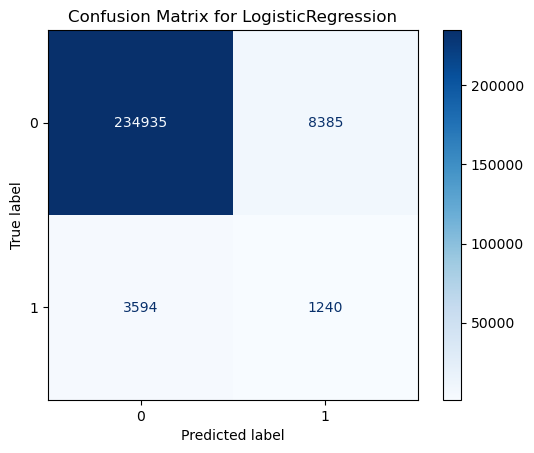

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    243320
           1       0.24      0.29      0.26      4834

    accuracy                           0.97    248154
   macro avg       0.61      0.64      0.62    248154
weighted avg       0.97      0.97      0.97    248154



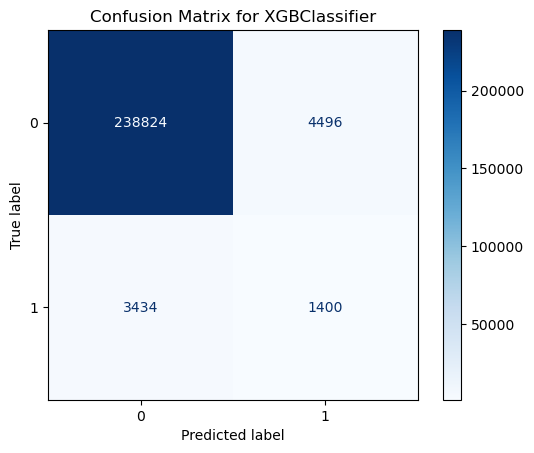

In [778]:
##Validation
cutoff = 0.85
## store the predicted probabilities
y_prob = log_reg.predict_proba(StandardScaler().fit_transform(test_features.values))[:,1]
## assign the value based on the cutoff
y_pred = 1*(y_prob >= cutoff)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {log_reg.__class__.__name__}')
plt.show()


cutoff = 0.5
## store the predicted probabilities
y_prob = xgb.predict_proba(StandardScaler().fit_transform(test_features.values))[:,1]
## assign the value based on the cutoff
y_pred = 1*(y_prob >= cutoff)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {xgb.__class__.__name__}')
plt.show()

In [ ]:
##Looking at the correlation matrix for our features in our training data
corr_matrix = pd.concat([train_features,total_data[:1000000]['Label']],axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()